In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from itertools import combinations as comb

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_prefix = '/content/drive/MyDrive/final project/'

file = "churn.csv"

In [4]:
churn = pd.read_csv(path_prefix+file)
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
drop = ['RowNumber','CustomerId','Surname']
churn.drop(drop, axis=1, inplace=True)

In [6]:
churn_num = churn.select_dtypes('number').columns
churn_cat = churn.select_dtypes('object').columns

# Splitting and Feature Selection

In [7]:
X = churn.drop('Exited', axis=1)
y = churn['Exited']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.2)

print(f'shape X_train: {X_train.shape}')
print(f'shape X_test: {X_test.shape}')
print(f'shape y_train: {y_train.shape}')
print(f'shape y_test: {y_test.shape}')

shape X_train: (8000, 10)
shape X_test: (2000, 10)
shape y_train: (8000,)
shape y_test: (2000,)


In [8]:
def train_pre(X_train, X_test):
    X_train_enc = X_train.copy()
    X_num = X_train_enc.select_dtypes('number').columns
    X_cat = X_train_enc.select_dtypes('object').columns
    
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    X_train_enc[X_cat] = oe.fit_transform(X_train_enc[X_cat])
    
    knn = KNNImputer(n_neighbors=5)
    X_train_imp = pd.DataFrame(knn.fit_transform(X_train_enc), columns=X_train_enc.columns)
    
    X_train_imp[X_cat] = oe.inverse_transform(X_train_imp[X_cat])
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))
    
    ss = StandardScaler()
    X_train_ss = pd.DataFrame(ss.fit_transform(X_train_imp[X_num]),
                              columns= X_num)
    
    X_train_trans = pd.concat([X_train_ss, X_train_ohe], axis=1)
    
    X_test_enc = X_test.copy()
    
    X_test_enc[X_cat] = oe.transform(X_test_enc[X_cat])
    X_test_imp = pd.DataFrame(knn.transform(X_test_enc), columns=X_train_enc.columns)
    X_test_imp[X_cat] = oe.inverse_transform(X_test_imp[X_cat])
    X_test_ohe = pd.DataFrame(ohe.transform(X_test_imp[X_cat]).toarray(),
                               columns=ohe.get_feature_names_out(X_cat))
    X_test_ss = pd.DataFrame(ss.transform(X_test_imp[X_num]),
                              columns= X_num)
    X_test_trans = pd.concat([X_test_ss, X_test_ohe], axis=1)
    
    return X_train_trans, X_test_trans

In [9]:
X_train_trans = train_pre(X_train, X_test)[0]
X_test_trans = train_pre(X_train, X_test)[1]

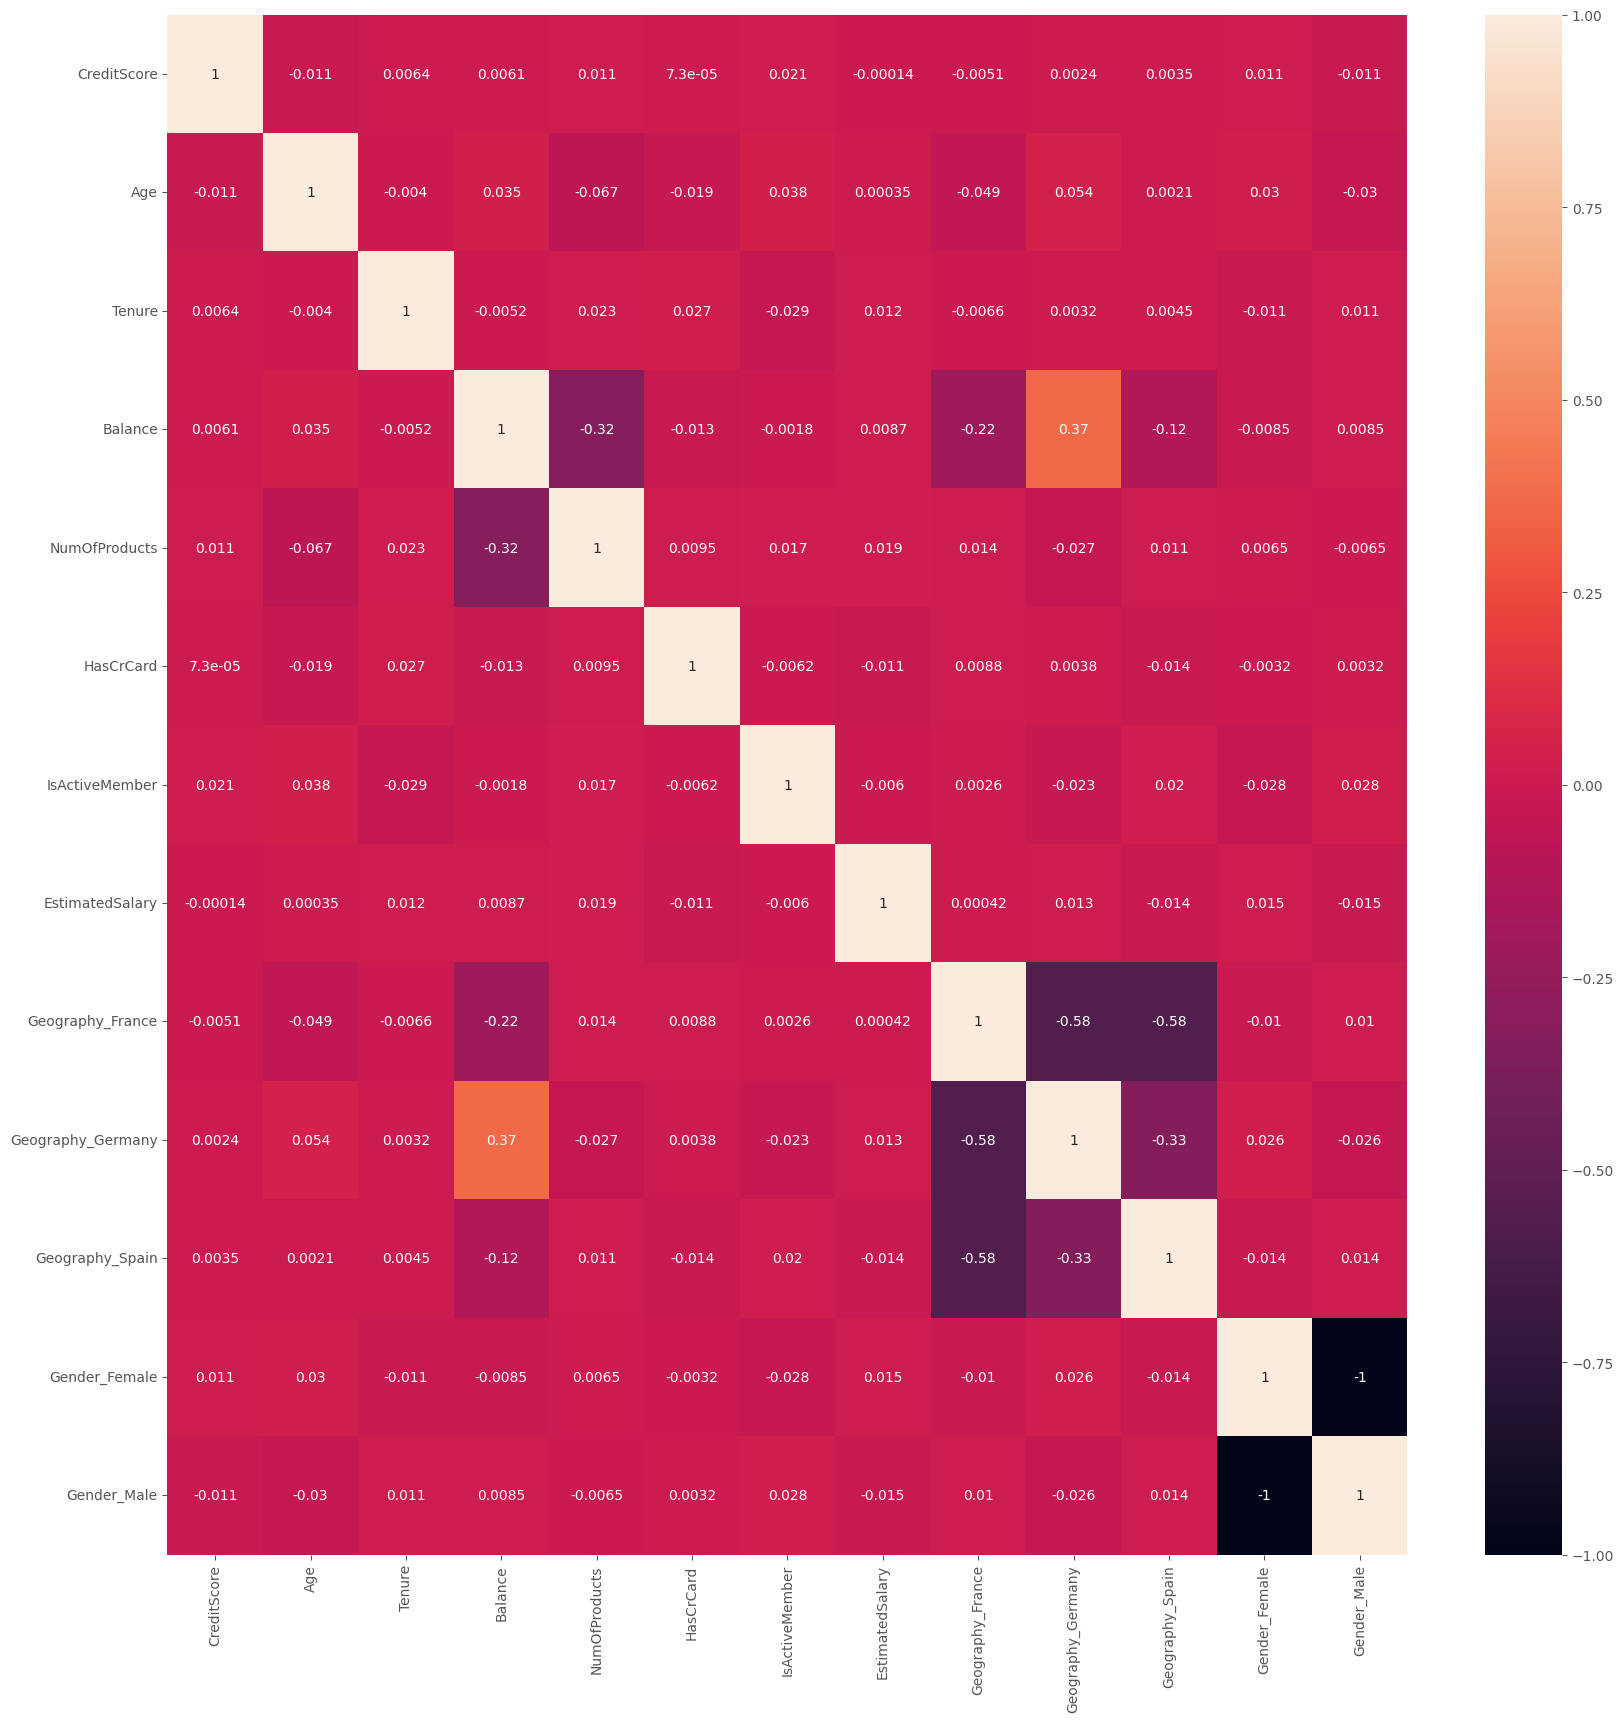

In [10]:
plt.figure(figsize=(20,20))
corr = X_train_trans.corr(method='spearman')
sns.heatmap(corr,vmin=-1, vmax=1, annot=True)
plt.show()

# Oversampling: ADASYN

In [12]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42, n_jobs= -1)

X_train_trans, y_train = ada.fit_resample(X_train_trans, y_train)

X_test_trans, y_test = ada.fit_resample(X_test_trans, y_test)

# Numerical Univariate

In [14]:
def outlier(x):
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lower_fence = q1 - (1.5 * iqr)
    upper_fence = q3 + (1.5 * iqr)
    
    outlier = []
    for num in x:
        if num < lower_fence:
            outlier.append(num)
        if num > upper_fence:
            outlier.append(num)
            
    non_outlier = []
    for num in x:
        if num >= lower_fence:
            non_outlier.append(num)
        if num <= upper_fence:
            non_outlier.append(num)
    
 #   print(f'sum of unique value : {len(outlier)}' )
  #  print(f'lower_value: {np.min(non_outlier)}')
  #  print(f'upper_vaue: {np.max(non_outlier)}')

1. CreditScore


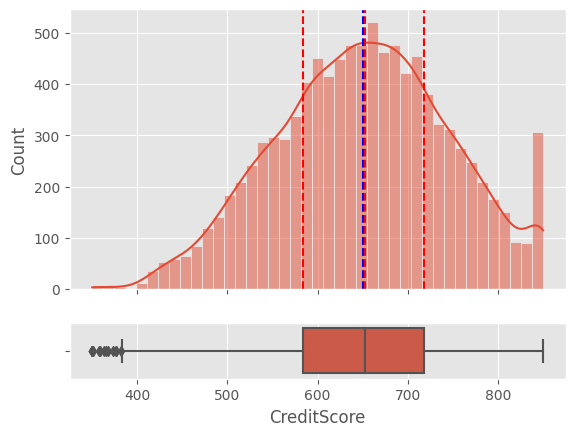

 
 
 
Data skewed with skew is -2.921350049463535
 
Data not normal
--------------------------------------------------
 
2. Age


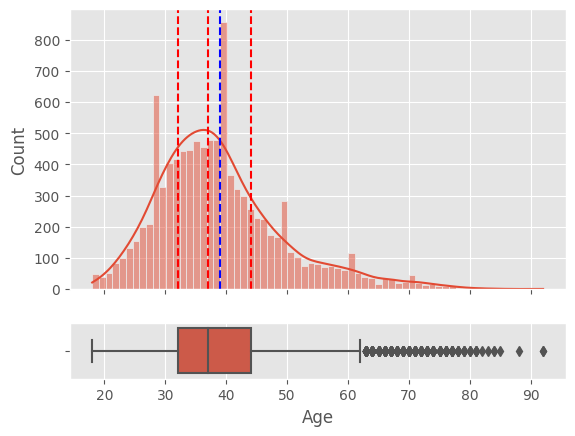

 
 
 
Data skewed with skew is 34.71381902710585
 
Data not normal
--------------------------------------------------
 
3. Tenure


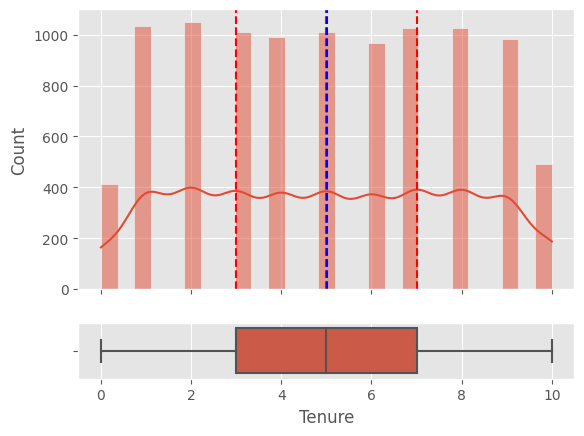

 
 
 
Data not skewed
 
Data not normal
--------------------------------------------------
 
4. Balance


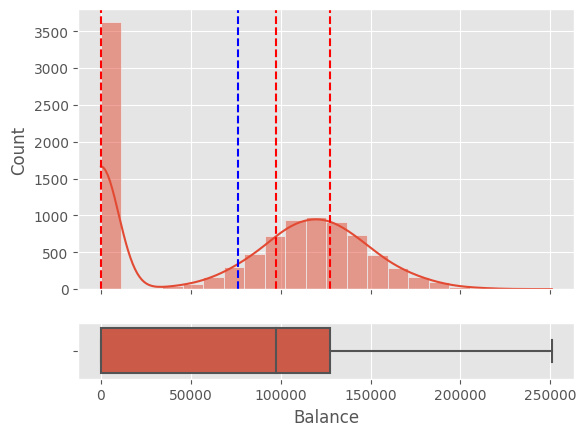

 
 
 
Data skewed with skew is -5.735943388118224
 
Data not normal
--------------------------------------------------
 
5. NumOfProducts


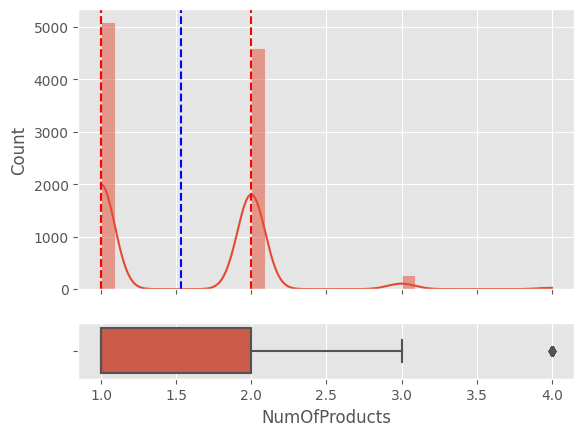

 
 
 
Data skewed with skew is 27.308956247437614
 
Data not normal
--------------------------------------------------
 
6. HasCrCard


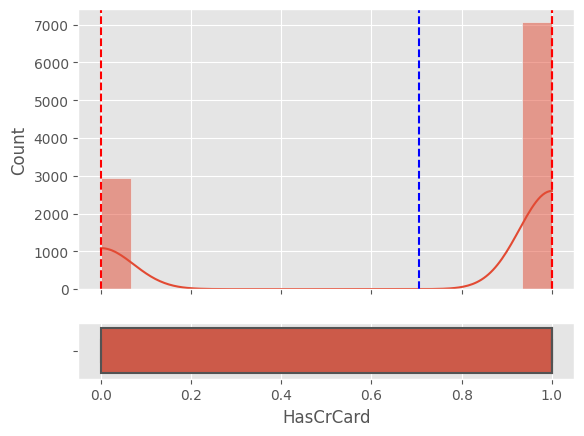

 
 
 
Data skewed with skew is -31.80680270602491
 
Data not normal
--------------------------------------------------
 
7. IsActiveMember


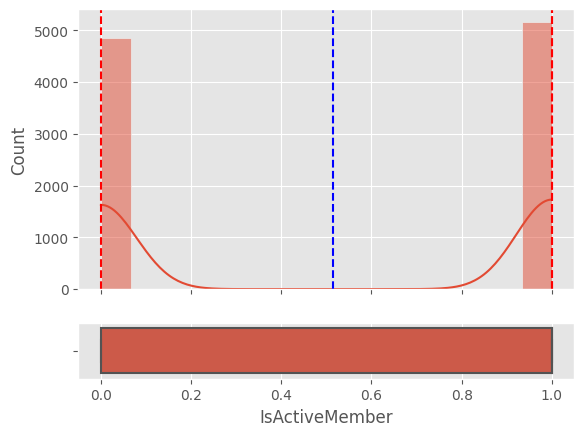

 
 
 
Data skewed with skew is -2.466548666286503
 
Data not normal
--------------------------------------------------
 
8. EstimatedSalary


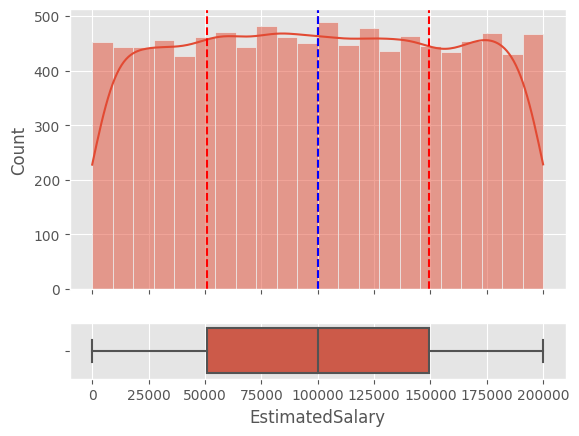

 
 
 
Data not skewed
 
Data not normal
--------------------------------------------------
 
9. Exited


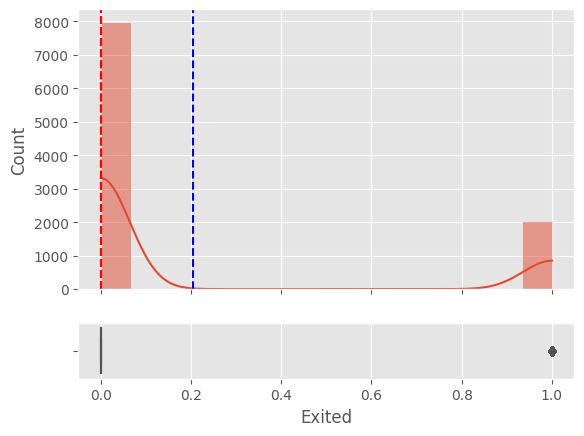

 
 
 
Data skewed with skew is 45.099913008252294
 
Data not normal
--------------------------------------------------
 


In [15]:
norm_data = []
for y,x in enumerate(churn_num,1):
    print(f'{y}. {x}')
    fig, ax = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios':[5,1]})
    sns.histplot(data=churn, x=x, kde=True, ax=ax[0])
    ax[0].axvline(np.nanpercentile(churn[x], 25), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(churn[x], 50), c='red',linestyle='--')
    ax[0].axvline(np.nanpercentile(churn[x], 75), c='red',linestyle='--')
    ax[0].axvline(np.mean(churn[x]), c='blue',linestyle='--')
    
    sns.boxplot(data=churn, x=x, ax=ax[1])
    ax[1].set_xlabel(f'{x}')
    plt.show()
    print(' ')
    churn[x].describe()
    print(' ')
    outlier(churn[x])
    print(' ')
    sk, pval = st.skewtest(churn[x])
    if pval < 0.05:
        print(f'Data skewed with skew is {sk}')
    else:
        print(f'Data not skewed')
    print(' ')
    norm, pval = st.normaltest(churn[x])
    if pval < 0.05:
        print(f'Data not normal')
    else:
        print(f'Data normal')
        norm_data.append(x)
    print('-'*50)
    print(' ')

# Feature Selection

In [16]:
drop = []

for col1, col2 in comb(X_train_trans.columns, 2):
    if (col1 in norm_data) & (col2 in norm_data):
        pear, pval1 = st.pearsonr(X_train_trans[col1],X_train_trans[col2])
        if (pear > 0.8) | (pear < -0.8):
            drop.append(col1)
    else:
        spear, pval2 = st.spearmanr(X_train_trans[col1],X_train_trans[col2])
        if (spear > 0.8) | (spear < -0.8):
            drop.append(col1)
        
drop

['Gender_Female']

In [17]:
X_train_trans.drop(drop, axis=1, inplace=True)
X_test_trans.drop(drop, axis=1, inplace=True)

In [18]:
mi_col = pd.DataFrame({'col': X_train_trans.columns,
                       'mi':mutual_info_classif(X_train_trans, y_train, random_state=42)}).sort_values('mi')
mi_col

,col,mi
7,EstimatedSalary,0.004444
5,HasCrCard,0.010226
6,IsActiveMember,0.014105
10,Geography_Spain,0.033547
3,Balance,0.035230
11,Gender_Male,0.036205
8,Geography_France,0.043222
9,Geography_Germany,0.047435
4,NumOfProducts,0.096998
2,Tenure,0.251017


In [19]:
sel = mi_col[mi_col['mi'] !=0]
sel

,col,mi
7,EstimatedSalary,0.004444
5,HasCrCard,0.010226
6,IsActiveMember,0.014105
10,Geography_Spain,0.033547
3,Balance,0.035230
11,Gender_Male,0.036205
8,Geography_France,0.043222
9,Geography_Germany,0.047435
4,NumOfProducts,0.096998
2,Tenure,0.251017


In [20]:
X_train_trans = X_train_trans[sel['col']]
X_train_trans

,EstimatedSalary,HasCrCard,IsActiveMember,Geography_Spain,Balance,Gender_Male,Geography_France,Geography_Germany,NumOfProducts,Tenure,CreditScore,Age
0,1.042084,0.641042,-1.030206,0.0,-1.226059,1.0,1.000000,0.000000,-0.910256,0.684723,1.058568,1.715086
1,-0.623556,0.641042,-1.030206,0.0,0.413288,1.0,0.000000,1.000000,-0.910256,-0.696202,0.913626,-0.659935
2,0.308128,0.641042,0.970680,0.0,0.601687,0.0,0.000000,1.000000,0.808830,-1.731895,1.079274,-0.184931
3,-0.290199,0.641042,-1.030206,0.0,-1.226059,1.0,1.000000,0.000000,0.808830,-0.005739,-0.929207,-0.184931
4,0.135042,-1.559960,0.970680,0.0,0.548318,1.0,0.000000,1.000000,0.808830,0.339492,0.427035,0.955079
...,...,...,...,...,...,...,...,...,...,...,...,...
12681,-1.451776,0.641042,0.970680,0.0,0.707209,1.0,0.576069,0.423931,-0.910256,-0.842556,-1.033746,0.085618
12682,-1.467934,0.641042,0.970680,0.0,0.904816,1.0,1.000000,0.000000,-0.910256,-0.719150,-1.085311,0.049276
12683,-1.294784,0.641042,-1.030206,1.0,-1.226059,0.0,0.000000,0.000000,-0.910256,0.339492,0.385590,-0.373126
12684,-1.399529,0.641042,-1.030206,1.0,-0.723101,0.0,0.000000,0.000000,-0.910256,0.339492,0.212259,-0.424646


In [21]:
X_test_trans = X_test_trans[sel['col']]
X_test_trans

,EstimatedSalary,HasCrCard,IsActiveMember,Geography_Spain,Balance,Gender_Male,Geography_France,Geography_Germany,NumOfProducts,Tenure,CreditScore,Age
0,-0.095021,0.641042,-1.030206,0.0,-1.226059,1.000000,1.000000,0.000000,0.808830,0.684723,-0.680735,-0.279932
1,-0.778941,-1.559960,-1.030206,0.0,0.877113,1.000000,0.000000,1.000000,0.808830,-0.350971,-1.301915,-0.564935
2,0.099469,-1.559960,0.970680,1.0,-1.226059,0.000000,0.000000,0.000000,0.808830,-0.350971,-0.970619,0.100072
3,-1.147374,-1.559960,-1.030206,1.0,1.011458,1.000000,0.000000,0.000000,0.808830,-0.005739,-0.121674,-0.469934
4,1.200283,0.641042,0.970680,1.0,0.023204,0.000000,0.000000,0.000000,-0.910256,-0.696202,-0.111321,-0.469934
...,...,...,...,...,...,...,...,...,...,...,...,...
3232,-1.028524,-1.559960,0.970680,0.0,0.639309,0.695249,0.000000,1.000000,-0.910256,1.029954,1.722059,0.347977
3233,0.550478,-1.559960,0.970680,0.0,0.469451,1.000000,0.000000,1.000000,-0.910256,0.743621,1.109683,0.526453
3234,-0.374440,-1.559960,0.970680,0.0,0.620152,1.000000,0.000000,1.000000,-0.910256,0.932764,1.739289,0.370308
3235,-0.046716,-1.559960,0.970680,0.0,0.459868,1.000000,0.872754,0.127246,-0.910256,1.029954,0.327970,0.290073


# Parameter

In [22]:
logreg_def = LogisticRegression(random_state=42)
tree_def = DecisionTreeClassifier(random_state=42)
rf_def = RandomForestClassifier(random_state=42)
xgb_def = XGBClassifier(random_state=42)

In [23]:
model = [logreg_def,tree_def,rf_def,xgb_def]
model_list = ['logreg_def', 'tree_def','rf_def','xgb_def']

Logistic Regression

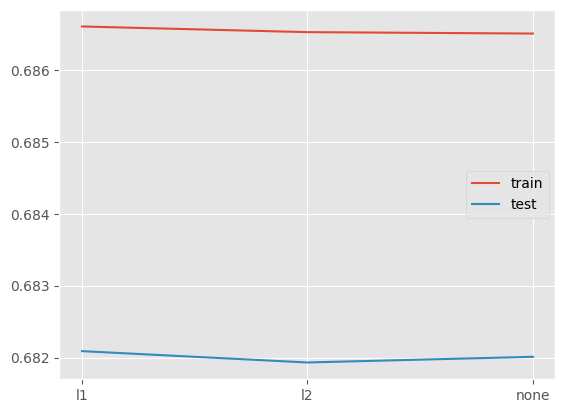

'l1'

In [24]:
x = ['l1','l2','none']
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

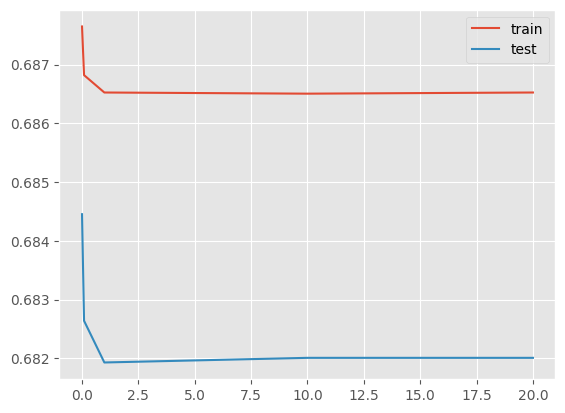

0.01

In [25]:
x = [0.01, 0.1, 1, 10, 20]
train = []
test = []

for val in x:
    logreg2 = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l2',
                                 C=val)
    cv = cross_validate(logreg2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [26]:
logreg_tun = LogisticRegression(random_state=42,
                                 solver='saga',
                                 penalty='l1',
                                 C=0.01)
model.append(logreg_tun)
model_list.append('logreg_tun')

Decision Tree

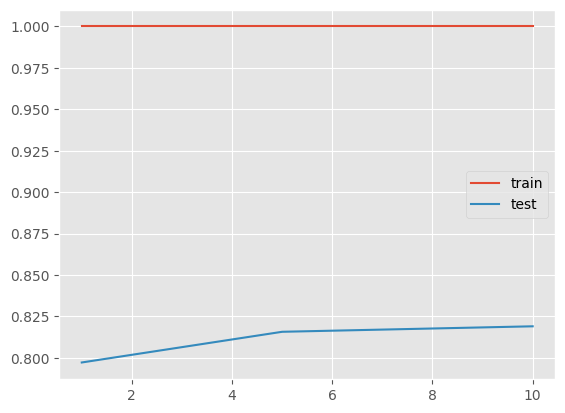

10

In [27]:
x = [1,5,10]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

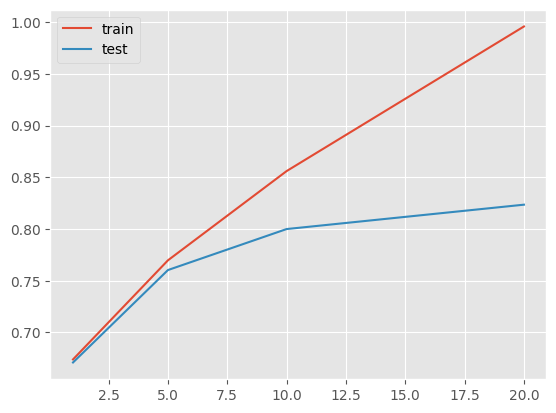

20

In [28]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=9,
                                   max_depth=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

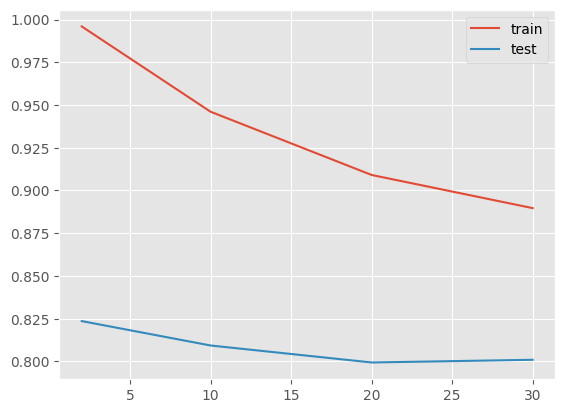

2

In [32]:
x = [2,10,20,30]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=9,
                                   max_depth=20,
                                   min_samples_split=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

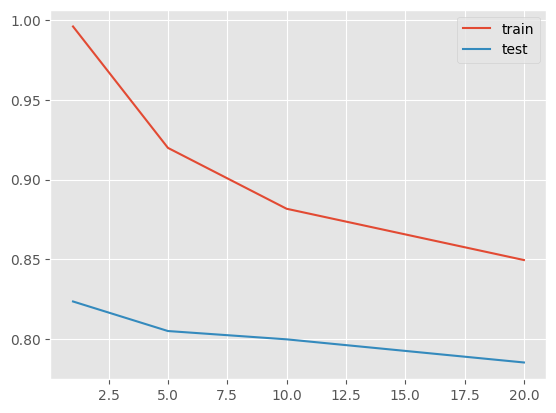

1

In [37]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=9,
                                   max_depth=20,
                                   min_samples_split=2,
                                   min_samples_leaf=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

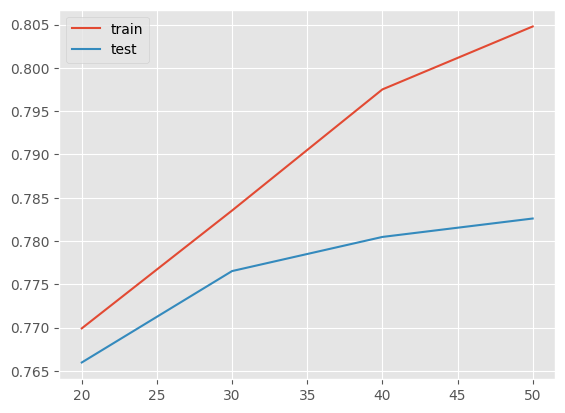

50

In [38]:
x = [20,30,40,50]
train = []
test = []

for val in x:
    tree2 = DecisionTreeClassifier(random_state=42,
                                   max_features=9,
                                   max_depth=20,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   max_leaf_nodes=val)
    cv = cross_validate(tree2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [39]:
tree_tun = DecisionTreeClassifier(random_state=42,
                                   max_features=9,
                                   max_depth=20,
                                   min_samples_split=2,
                                   min_samples_leaf=1,
                                   max_leaf_nodes=50)

model.append(tree_tun)
model_list.append('tree_tun')

Random Forest

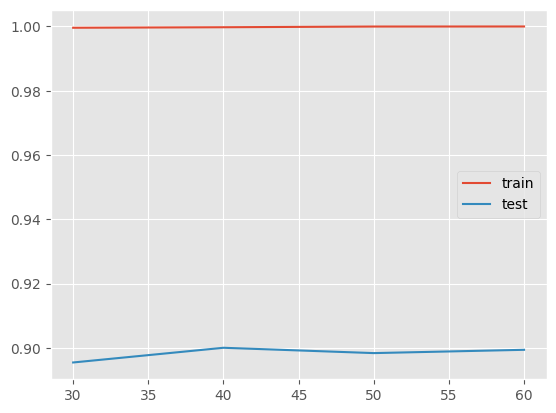

40

In [41]:
x = [30,40,50,60]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

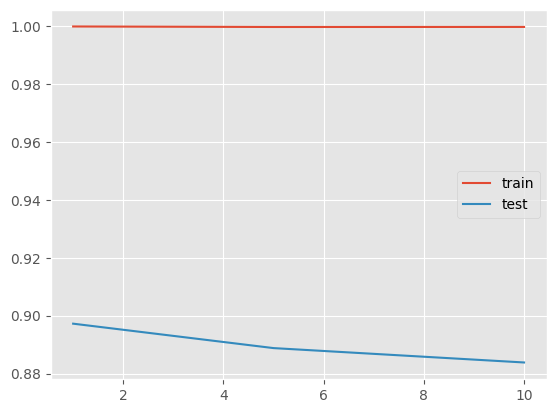

1

In [42]:
x = [1,5,10]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=40,
                                 max_features=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

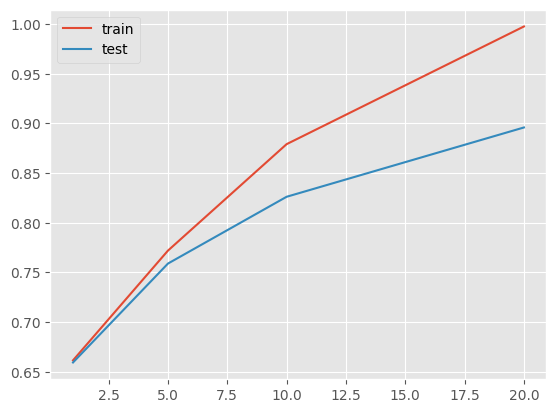

20

In [43]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=40,
                                 max_features=1,
                                 max_depth=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

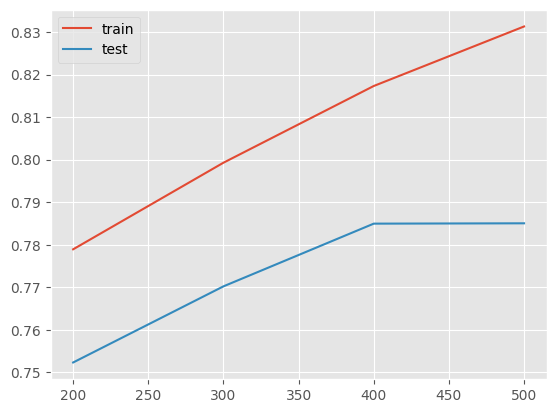

500

In [44]:
x = [200,300,400,500]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=40,
                                 max_features=1,
                                 max_depth=20,
                                 max_samples=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

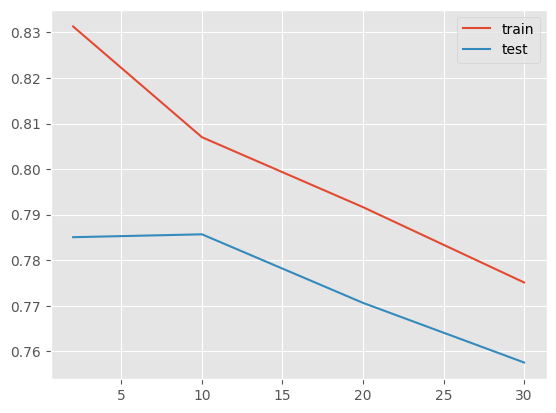

10

In [45]:
x = [2,10,20,30]
train = []
test = []

for val in x:
    rf2 = RandomForestClassifier(random_state=42,
                                 n_estimators=40,
                                 max_features=1,
                                 max_depth=20,
                                 max_samples=500,
                                 min_samples_split=val)
    cv = cross_validate(rf2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [46]:
rf_tun = RandomForestClassifier(random_state=42,
                                 n_estimators=80,
                                 max_features=1,
                                 max_depth=20,
                                 max_samples=500,
                                 min_samples_split=10)

model.append(rf_tun)
model_list.append('rf_tun')

xgboost

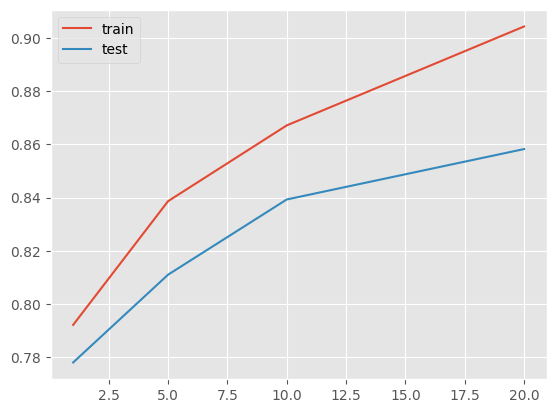

20

In [47]:
x = [1,5,10,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                        n_estimators=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

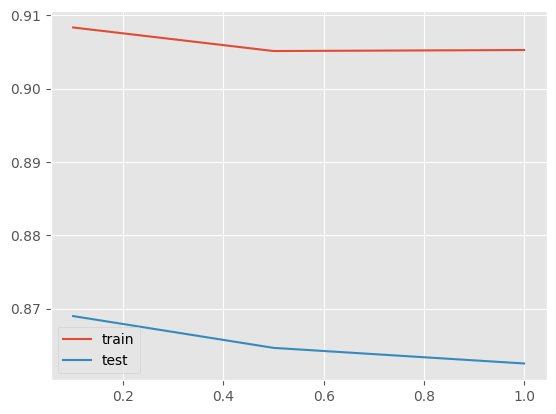

0.1

In [48]:
x = [0.1,0.5,1]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=20,
                         gamma=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

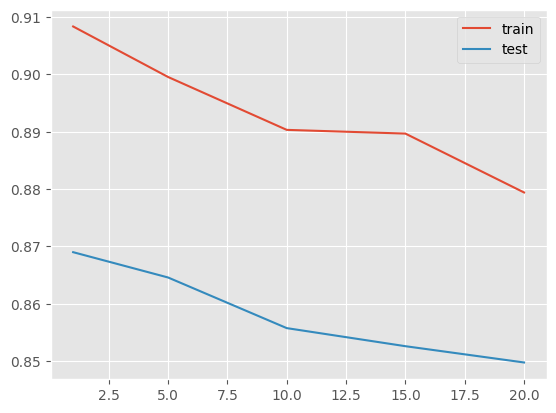

1

In [49]:
x = [1,5,10,15,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=20,
                         gamma=0.1,
                         reg_lambda=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

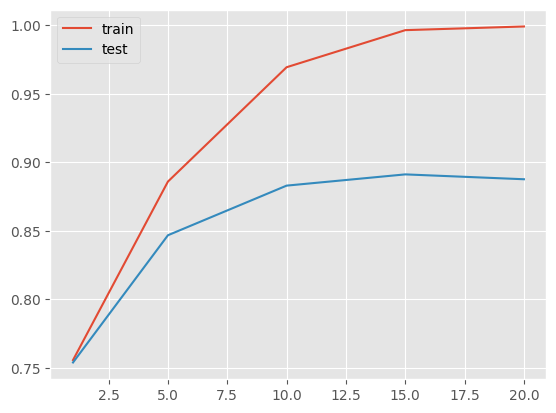

15

In [50]:
x = [1,5,10,15,20]
train = []
test = []

for val in x:
    xgb2 = XGBClassifier(random_state=42,
                         n_estimators=20,
                         gamma=0.1,
                         reg_lambda=1,
                         max_depth=val)
    cv = cross_validate(xgb2, X_train_trans, y_train, return_train_score=True)
    train.append(cv['train_score'].mean())
    test.append(cv['test_score'].mean())

sns.lineplot(x=x, y=train, label='train')
sns.lineplot(x=x, y=test, label='test')
plt.show()

x[np.argmax(test)]

In [51]:
xgb_tun = XGBClassifier(random_state=42,
                         n_estimators=20,
                         gamma=0.1,
                         reg_lambda=1,
                        max_depth=15)

model.append(xgb_tun)
model_list.append('xgb_tun')

# Result

In [52]:
score = {'model': [],
         'acc': [],
         'roc': [],
         'recall': [],
         'f1_score': [],
         'npv': []}

for mod, mods in zip(model, model_list):
    for y in ['_test','_train']:
        if y == '_test':
            mod.fit(X_train_trans, y_train)
            tn1, fp1, fn1, tp1 = confusion_matrix(y_test, mod.predict(X_test_trans)).ravel()
            score['model'].append(mods+y)
            score['acc'].append(mod.score(X_test_trans, y_test))
            score['roc'].append(roc_auc_score(y_test, mod.predict_proba(X_test_trans)[:,1]))
            score['recall'].append(recall_score(y_test, mod.predict(X_test_trans)))
            score['f1_score'].append(f1_score(y_test, mod.predict(X_test_trans)))
            score['npv'].append(tn1/(tn1+fn1))
        elif y =='_train':
            mod.fit(X_train_trans, y_train)
            tn, fp, fn, tp = confusion_matrix(y_train, mod.predict(X_train_trans)).ravel()
            score['model'].append(mods+y)
            score['acc'].append(mod.score(X_train_trans, y_train))
            score['roc'].append(roc_auc_score(y_train, mod.predict_proba(X_train_trans)[:,1]))
            score['recall'].append(recall_score(y_train, mod.predict(X_train_trans)))
            score['f1_score'].append(f1_score(y_train, mod.predict(X_train_trans)))
            score['npv'].append(tn/(tn+fn))

pd.DataFrame(score).sort_values(['roc', 'acc', 'recall', 'f1_score','npv'], ascending=False)

,model,acc,roc,recall,f1_score,npv
3,tree_def_train,1.000000,1.000000,1.000000,1.000000,1.000000
5,rf_def_train,1.000000,1.000000,1.000000,1.000000,1.000000
15,xgb_tun_train,0.995349,0.999708,0.995725,0.995331,0.995758
7,xgb_def_train,0.966814,0.995568,0.948385,0.966051,0.950614
6,xgb_def_test,0.898672,0.957809,0.868613,0.896985,0.872717
14,xgb_tun_test,0.869323,0.939873,0.832725,0.866182,0.840116
4,rf_def_test,0.842138,0.916719,0.790146,0.835638,0.805305
13,rf_tun_train,0.807504,0.892132,0.787682,0.802937,0.797126
12,rf_tun_test,0.797652,0.886560,0.787713,0.798151,0.786675
11,tree_tun_train,0.798597,0.875389,0.782932,0.794697,0.790910


Feature Importance

In [53]:
fi = pd.DataFrame(xgb_tun.feature_importances_,
                  index=xgb_tun.feature_names_in_,
                  columns=['importance']).sort_values(['importance'], ascending=False)
fi

,importance
NumOfProducts,0.417639
Geography_Germany,0.136061
Age,0.097345
IsActiveMember,0.052248
Gender_Male,0.052209
Geography_France,0.049892
Geography_Spain,0.045382
Balance,0.045282
Tenure,0.031810
HasCrCard,0.025129


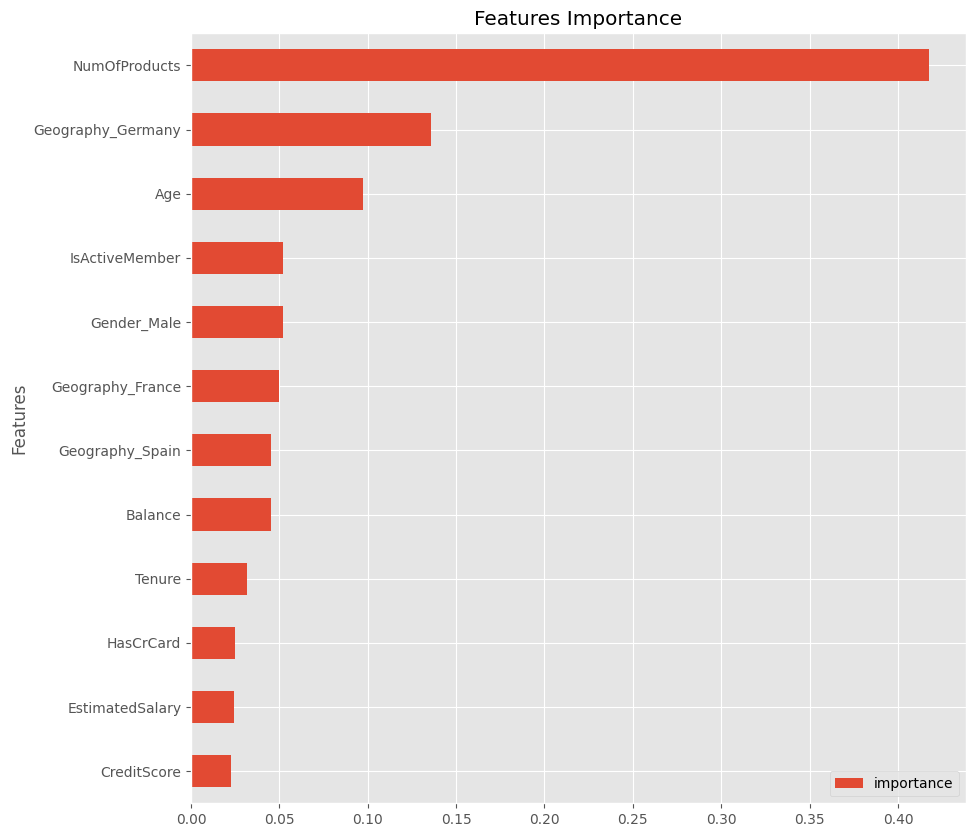

In [54]:
ax = fi.sort_values('importance').plot(kind='barh', title='Features Importance', figsize=(10,10))
ax.set_ylabel('Features')
plt.show()
